In [59]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 21932849.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 8085415.42it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22824648.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21846936.66it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 11, 4, 2)
        self.conv2 = nn.Conv2d(64, 192, 5, 1, 2)
        self.conv3 = nn.Conv2d(192, 384, 3, 1, 1)
        self.conv4 = nn.Conv2d(384, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 256, 3, 2, 1)

        self.maxpool = nn.MaxPool2d(2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.relu = nn.ReLU(inplace=True)

        self.dropout = nn.Dropout(0.5)
        self.linear1 = nn.Linear(9216, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096,10)


    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
       # x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)

        output = F.log_softmax(x, dim=1) 
        return output

In [68]:
model = Net().to("mps")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses = []

for epoch in range(20):
     for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to("mps"), target.to("mps")
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302128
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.301184
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.300109
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.304980
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.300539
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.302698
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.304268
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.305591
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.302567
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.303118
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304557
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.308529
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.296481
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.299987
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.309984
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.299234
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.296135
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.301430
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.302186
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.297624
Train Epoch:

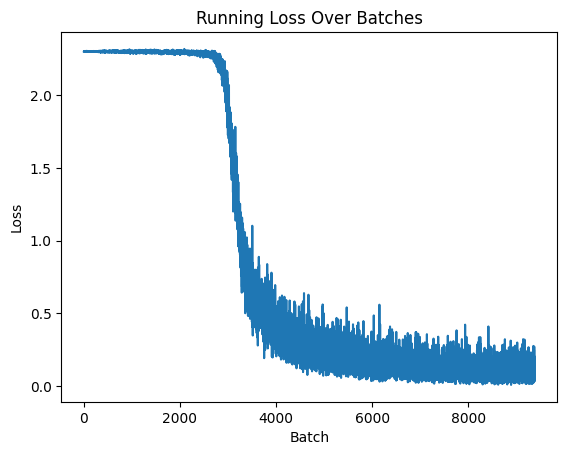

In [64]:
plt.plot(losses)
plt.title("Running Loss Over Batches")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

In [65]:
model.eval()
correct = 0
total = 0


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("mps"), labels.to("mps")
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy}%")

Accuracy on the test set: 97.44%
